You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import os
import pandas as pd
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [4]:
def NGD_TK_AS(T,epsilon, omegastar, deltastar, tau_y, Bmp, NoDelay = False):
    if NoDelay: return -Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):50]

In [5]:
def ParaTrans(ASparadict):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, Amp 
    
    beta = epsilon-omegastar*np.tan(deltastar)
    alpha = epsilon+omegastar*np.tan(deltastar)
    g = omegastar**2 *(1+np.tan(deltastar)**2)
    Amp = Bmp*np.cos(deltastar)
    DiffParadict = {'alpha':[], 'beta':[],  'g':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

# Load Experimental data

## select files and channels

### From Exp

In [6]:
cn = 1
dt = 0.01
TKtaxis = np.arange(0,0.8,dt)

In [7]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGDASpara.npz', allow_pickle=True)
ASparadict = loadfiles['para_dict'][()]
DiffPara_dict = ParaTrans(ASparadict)

0.01783067721998834


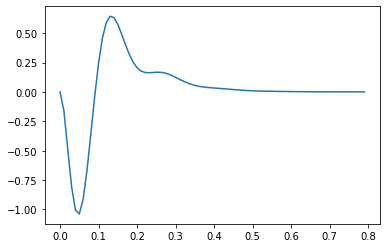

In [8]:
TK = NGD_TK_AS(TKtaxis, *pd.DataFrame(loadfiles['para_dict'][()]).loc[cn-1][:-1])
plt.plot(TKtaxis, TK)
longTK = np.append(np.zeros(len(TK)-1), TK)
print(sum(TK)*dt)

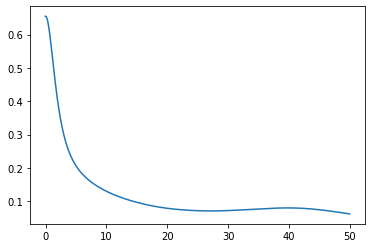

In [9]:
dOmega = 0.05
omega = np.arange(-dOmega ,50, dOmega)
F_TK = np.sum(TK[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta)

In [10]:
1/(beta[cn-1]+1)

-0.8412708994453647

In [11]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]

x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [12]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [13]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534, 0.432, 0.405, 0.395]

In [14]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

0.18000000000000682
0.0800000000000125
0.05000000000001137
-0.009999999999990905


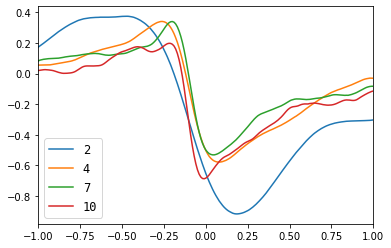

In [15]:
expXcorr_list = [0]*len(x_list)

for i in range(len(x_list)):
    expXcorr_list[i] = np.correlate(x_list[i], rstate_list[i], 'same')/np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same')
    Taxis = T_list[i]-T_list[i][int(len(T_list[i])/2)]
    plt.plot(Taxis, expXcorr_list[i])
    print(Taxis[np.argmin(expXcorr_list[i])])
    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

# Fake Spike from TK

In [16]:
fr_list = [np.convolve(x*2+10, longTK , 'same')*dt for x in x_list]

(150, 160)

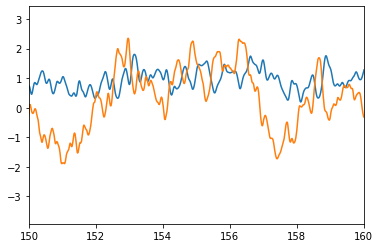

In [17]:
i = 3
plt.plot(T_list[i], 5*fr_list[i])
plt.plot(T_list[i], x_list[i])
plt.xlim([150, 160])

0.3381254573296203 2.8449869046462455
0.29224296717050324 1.7543228995100475
0.3120891104716329 1.9114774902823133
0.4005715015784941 3.079706222817796


Text(0.5, 0, 'centered-normalized threshold')

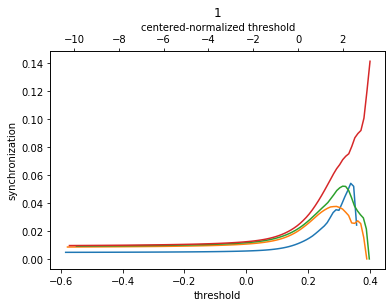

In [18]:
for i in range(len(x_list)):
    thetas = np.linspace(min(fr_list[i]), max(fr_list[i]), 100, endpoint = False)
    sync = [sum(rstate_list[i]*NL(fr_list[i],theta)/sum(NL(fr_list[i],theta))) for theta in thetas]
    plt.plot(thetas, sync)
#     ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
    print(thetas[np.argmax(sync)], (thetas[np.argmax(sync)]-np.mean(fr_list[i]))/np.std(fr_list[i]))
    
plt.title(str(cn))
plt.xlabel('threshold')
plt.ylabel('synchronization')

ax2 = plt.gca().twiny()
ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
ax2.plot(np.linspace(min(ncfc), max(ncfc), 100), np.zeros(100)) # Create a dummy plot
ax2.lines = []
ax2.set_xlabel('centered-normalized threshold')

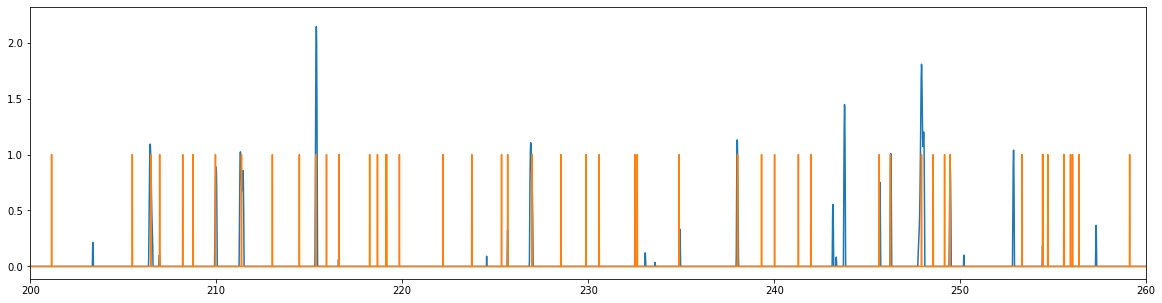

In [19]:
plt.plot(T_list[i], 20*NL(fr_list[i],0.3))
plt.plot(T_list[i], rstate_list[i])
plt.xlim([200, 260])
plt.gcf().set_size_inches(20, 5)

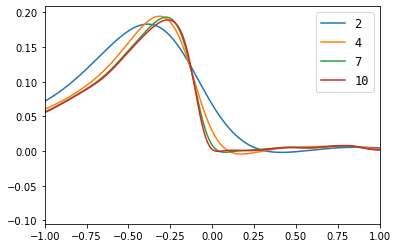

In [20]:
Xcorr_list = [0]*len(x_list)

for i in range(len(x_list)):
    Taxis = T_list[i]-T_list[i][int(len(T_list[i])/2)]
    plt.plot(Taxis, (np.correlate(x_list[i], NL(fr_list[i],-0.09), 'same')
                   /np.correlate(np.ones_like(x_list[i]), NL(fr_list[i],-0.09), 'same')))
    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

Text(0, 0.5, 'STA minimum')

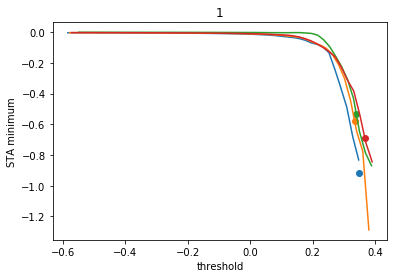

In [21]:
for i in range(len(x_list)):
    thetas = np.flip(np.linspace(np.min(fr_list[i]), max(fr_list[i]), 50, endpoint = False))
    STApeak = [min((np.correlate(x_list[i], NL(fr_list[i],theta), 'same')
                   /np.correlate(np.ones_like(x_list[i]), NL(fr_list[i],theta), 'same'))[14900:15100])
                for theta in thetas]
    plt.plot(thetas, STApeak)
    plt.scatter( np.interp(min(expXcorr_list[i]), STApeak, thetas), min(expXcorr_list[i]))
    
plt.title(str(cn))
plt.xlabel('threshold')
plt.ylabel('STA minimum')